In [15]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/yellow_tripdata_combined_cleaned_focus.csv")

In [ ]:
df["pickup_at"] = pd.to_datetime(df["pickup_at"])
df["dropoff_at"] = pd.to_datetime(df["dropoff_at"])
df["pickup_at_hour"] = df["pickup_at"].dt.round("H")

# Explainer notebook

## Motivation

### Dataset
In this project we consider the [New York City taxi dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) from year 2022. This dataset contains extensive information about Yello Taxi Trips in the time period. In the following cell a snippet of the data can be seen.

In [3]:
df.head()

,Unnamed: 0,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,pickup_at,dropoff_at,duration,pickup_at_hour
0,0,3.80,142,236,14.5,3.65,21.95,2022-01-01 00:35:40,2022-01-01 00:53:29,1069.0,2022-01-01 01:00:00
1,1,2.10,236,42,8.0,4.00,13.30,2022-01-01 00:33:43,2022-01-01 00:42:07,504.0,2022-01-01 01:00:00
2,2,0.97,166,166,7.5,1.76,10.56,2022-01-01 00:53:21,2022-01-01 01:02:19,538.0,2022-01-01 01:00:00
3,3,1.09,114,68,8.0,0.00,11.80,2022-01-01 00:25:21,2022-01-01 00:35:23,602.0,2022-01-01 00:00:00
4,4,4.30,68,163,23.5,3.00,30.30,2022-01-01 00:36:48,2022-01-01 01:14:20,2252.0,2022-01-01 01:00:00


Furthermore we also include data from [NYC Taxi Zones](https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc) to obtain the GeoJSON files of New York as well as [Historical Weather API](https://open-meteo.com/en/docs/historical-weather-api#latitude=40.71&longitude=-74.01&start_date=2023-04-14&end_date=2023-04-28&hourly=temperature_2m) for New York City in 2022. 

In [4]:
df_weather = pd.read_csv("data/weather_hourly.csv", index_col=False)
df_weather["time"] = pd.to_datetime(df_weather["time"])

From this dataset we extract whether a given hour had precipitation or not. 

In [5]:
df_weather.head()

,time,precipitation (mm)
0,2022-01-01 00:00:00,0.0
1,2022-01-01 01:00:00,0.0
2,2022-01-01 02:00:00,0.0
3,2022-01-01 03:00:00,0.7
4,2022-01-01 04:00:00,0.0


With these two dataset we seek to gain an insight into the Taxi Habbits of the New Yorkers. We chose this dataset since it allows for exploring many interesting patterns in the data. Working with a large amount of data however requires a structured analysis. In this project we focus on investigating which factors leads to certain habbits eg. when (month, day, hour ect.) does most people hire a taxi? What is the average distance? How much tipping is done?. Furthermore we also include the location information and the weather Data.
<br> <br>
We highly focus on creating an interactive user experience. Since we have many features to consider we want to allow the user to choose their own investigation point and filter the data themself.  

## Data preprosesing and basic stats
When investigating the data we observed a lot of values which we considered outliers. Hence extensive data cleaning is necessary. When cleaning the data observations with invalid numbers are removed. Invalid numbers are found eg in payment type, where only 1 and 2 are valid. Furthermore we made some assumptions for example:

* Trip duration is >1 min but <3 hours
* Trip distance is >0 mile but <100 miles
* Total amount is >2.5 dollars but <1000 dollars

After preprocessing we now consider 37.067.625 observations in total which is a faily large amount of observations for a single year.

For further details the script *data_prep.ipynb* contains all information about data cleansing. 

The following code provides the basic statistics of the data

In [6]:
df.describe()

,Unnamed: 0,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,pickup_at,dropoff_at,duration,pickup_at_hour
count,3.706765e+07,3.706765e+07,3.706765e+07,3.706765e+07,3.706765e+07,3.706765e+07,3.706765e+07,37067652,37067652,3.706765e+07,37067652
mean,1.970508e+07,3.512883e+00,1.651794e+02,1.629559e+02,1.446963e+01,2.739632e+00,2.136825e+01,2022-07-04 15:09:37.626890496,2022-07-04 15:25:19.889251584,9.422624e+02,2022-07-04 15:09:40.824000
min,0.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,2.520000e+00,0.000000e+00,2.820000e+00,2001-01-01 00:03:14,2001-01-01 00:34:17,6.000000e+01,2001-01-01 00:00:00
25%,9.816651e+06,1.130000e+00,1.320000e+02,1.130000e+02,7.000000e+00,1.000000e+00,1.230000e+01,2022-04-07 13:21:44,2022-04-07 13:40:00.750000128,4.520000e+02,2022-04-07 13:00:00
50%,1.961736e+07,1.900000e+00,1.620000e+02,1.620000e+02,1.000000e+01,2.160000e+00,1.595000e+01,2022-06-30 13:30:10.500000,2022-06-30 13:47:18.500000,7.350000e+02,2022-06-30 14:00:00
75%,2.965097e+07,3.500000e+00,2.340000e+02,2.340000e+02,1.600000e+01,3.360000e+00,2.256000e+01,2022-10-04 08:27:25,2022-10-04 08:45:39.249999872,1.181000e+03,2022-10-04 08:00:00
max,3.952963e+07,9.946000e+01,2.650000e+02,2.650000e+02,2.500000e+02,1.250000e+02,3.727200e+02,2023-01-01 00:31:23,2023-01-01 01:13:01,1.080000e+04,2023-01-01 01:00:00
std,1.143821e+07,4.437931e+00,6.476444e+01,7.004514e+01,1.287828e+01,3.071818e+00,1.647917e+01,NaN,NaN,7.460766e+02,NaN


In the table above we observe that all variables now are in a reasonable range.

### Grouping of data
In order to handle the data more efficiently we divide the data into smaller csv files based on the time. In the script *export.ipynb* we group the data based on either day, month, zone or Pick-Up Zones and save them as cvs files. From these we add the following information to the dataframes

* Day- or nighttime
* Season
* Weather
* Manhattan or all of New York

In the following we load the cvs files

## Data analysis

In [58]:
df_day = pd.read_csv("output/day_out.csv")
df_month = pd.read_csv("output/month_out.csv")
df_zones = pd.read_csv("output/zones_out.csv")
df_PUzones = pd.read_csv("output/PUzones_out.csv")

In [59]:
df_day.rename(columns = {'pickup_at':'week day'}, inplace = True)
df_month.rename(columns = {'pickup_at':'month'}, inplace = True)

## Genre

We have choosen to visualize using the interactive slideshow genre from Segel and Heer. 
Highly reader-driven
Visual Narrative = 
Narrative structure = Interactive



## Visualization

In [66]:
def bar_plot(df, weather='all', season='all', time='all', pickup_area='all'):
    df_att = df
    if weather != 'all':
        df_att = df_att[df_att["weather"] == weather]
    if season != 'all':
        df_att = df_att[df_att["season"] == season]
    if pickup_area != 'all':
        df_att = df_att[df_att["pickup_area"] == pickup_area]
    if time != 'all':
        df_att = df_att[df_att["time"] == time]
    
    df_att = df_att[[df.columns[0],'number_of_trips']]
    df_att = df_att.set_index(df.columns[0])
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot()
    df_att.plot(ax=ax, kind='bar', xlabel=df.columns[0], ylabel="Occurences")
    ax.tick_params(axis='x', labelrotation = 0)
    fig.suptitle('Number of pickups per ' + df.columns[0])
    fig.tight_layout(rect=[0, 0, 1, 0.99])
    fig.show()

C:\Users\anned\AppData\Local\Temp\ipykernel_16232\1434113309.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


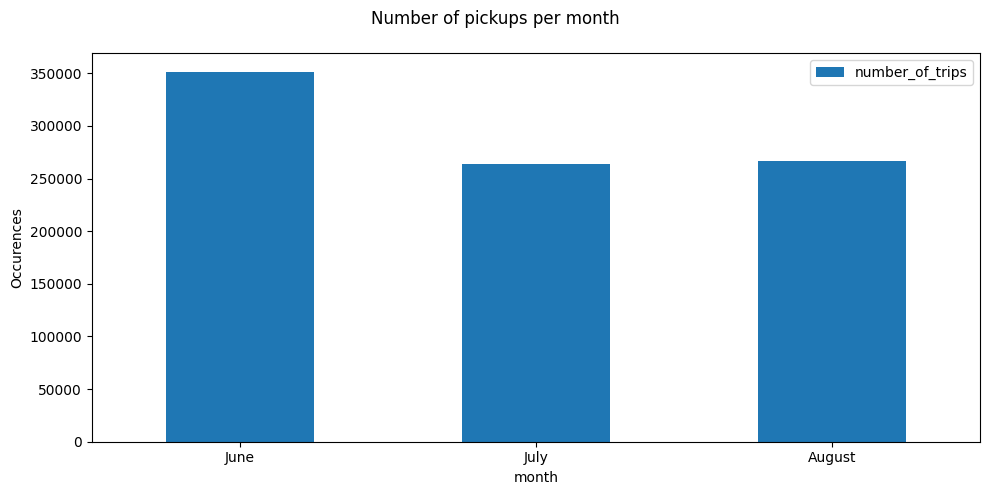

In [67]:
bar_plot(df_month, weather='rainy', season='summer', time='day', pickup_area='manhattan')

## Discussion

## Contributions